#### By: Peyman Shahidi
#### Created: Nov 3, 2025
#### Last Edit: Nov 3, 2025

<br>

In [68]:
#Python
import getpass
import numpy as np
import pandas as pd
from collections import defaultdict
import itertools
import random 

## formatting number to appear comma separated and with two digits after decimal: e.g, 1000 shown as 1,000.00
pd.set_option('float_format', "{:,.2f}".format)

import matplotlib.pyplot as plt
#%matplotlib inline
#from matplotlib.legend import Legend

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 200)

In [69]:
main_folder_path = ".."
input_data_path = f"{main_folder_path}/data"
output_data_path = f'{input_data_path}/computed_objects/ONET_Eloundou_Anthropic'
output_plot_path = f"{main_folder_path}/writeup/plots"

In [70]:
# Create directories if they don't exist
import os

for path in [output_data_path, output_plot_path]:
    if not os.path.exists(path):
        os.makedirs(path)

In [71]:
# Read O*NET data
ONET = pd.read_csv(f'{input_data_path}/computed_objects/ONET_cleaned_tasks.csv')

# Drop  columns to avoid double counting
# Note: In ~4k instances, the same task is mapped to multiple DWAs
ONET = ONET.drop(columns=['DWA ID', 'DWA Title'])

# Remove duplicate rows
rows_before = len(ONET)
print(f"Number of rows before removing duplicates: {rows_before:,}")
ONET = ONET.drop_duplicates().reset_index(drop=True)
rows_after = len(ONET)
print(f"Number of rows after removing duplicates: {rows_after:,}")
print(f"Duplicates removed: {rows_before - rows_after}")

# Print length of dataset
print(f"Number of rows in ONET dataset: {len(ONET):,}")

Number of rows before removing duplicates: 22,310
Number of rows after removing duplicates: 17,953
Duplicates removed: 4357
Number of rows in ONET dataset: 17,953


In [72]:
# Load GPTs are GPTs full label dataset
gpts_full_labels = pd.read_csv(f'{input_data_path}/GPTs-are-GPTs-main/data/full_labelset.tsv', sep="\t")

# Keep relevant columns only
gpts_full_labels = gpts_full_labels[['O*NET-SOC Code', 'Task ID', 'Task', 'Task Type', 'Title', 'gpt4_exposure', 'human_labels']]

# Convert Task ID to integer
gpts_full_labels['Task ID'] = gpts_full_labels['Task ID'].astype(int)

# Remove apostrophes for consistency
gpts_full_labels = gpts_full_labels.applymap(lambda x: x.replace("'", "") if isinstance(x, str) else x)

# Rename columns
gpts_full_labels = gpts_full_labels.rename(columns={
    'Task': 'Task Title',
    'Title': 'Occupation Title'
})

# Print length of dataset
print(f"Number of rows in GPTs full labels dataset: {len(gpts_full_labels):,}")

Number of rows in GPTs full labels dataset: 19,265


In [73]:
# Merge with ONET dataset to get hierarchical codes and titles
ONET = ONET.merge(gpts_full_labels, on=['O*NET-SOC Code', 'Occupation Title', 'Task ID', 'Task Title', 'Task Type'], how='left')

# Check how many tasks were not matched
unmatched_tasks = ONET[ONET['gpt4_exposure'].isna()]
print(f"Number of unmatched tasks: {len(unmatched_tasks):,}")

Number of unmatched tasks: 791


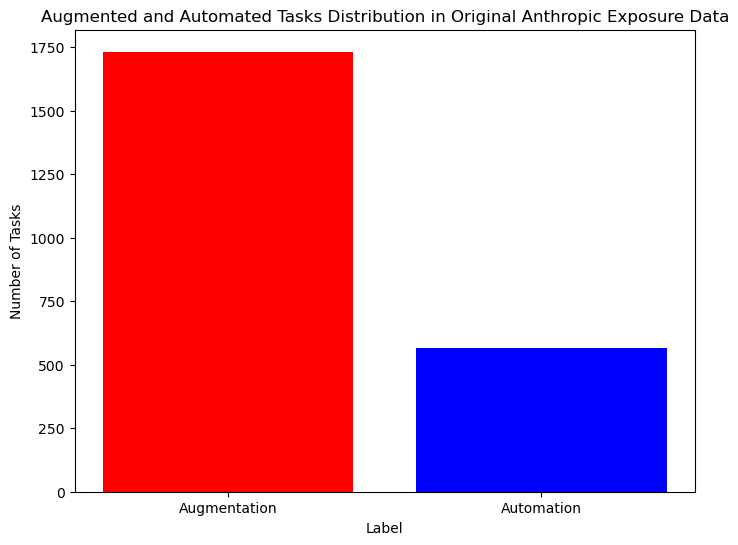

In [74]:
# Merge with Anthropic exposure data
anthropic_exposure = pd.read_csv(f'{input_data_path}/Anthropic_EconomicIndex/automation_vs_augmentation_by_task.csv')

# Remove if all entries are filtered:
anthropic_exposure = anthropic_exposure[anthropic_exposure['filtered'] != 1].reset_index(drop=True)

# Create new columns:
# Sum feedback loop and directive into Automation
# Sum validation, iteration, and learning into Augmentation
anthropic_exposure['automation'] = anthropic_exposure.apply(lambda row: row['feedback_loop'] + row['directive'], axis=1)
anthropic_exposure['augmentation'] = anthropic_exposure.apply(lambda row: row['validation'] + row['task_iteration'] + row['learning'], axis=1)

# Assign labels: take the max of automation, augmentation, manual and assign the corresponding label
def assign_label(row):
    max_value = max(row['automation'], row['augmentation'])
    if max_value == row['automation']:
        return 'Automation'
    elif max_value == row['augmentation']:
        return 'Augmentation'

anthropic_exposure['label'] = anthropic_exposure.apply(assign_label, axis=1)

# Filter to only keep the relevant columns
anthropic_exposure = anthropic_exposure[['task_name', 'automation', 'augmentation', 'label']]

# Plot histogram of the label column to see share of each label
label_counts = anthropic_exposure['label'].value_counts()
plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts.values, color=['red', 'blue'])
plt.title('Augmented and Automated Tasks Distribution in Original Anthropic Exposure Data')
plt.xlabel('Label')
plt.ylabel('Number of Tasks')
plt.savefig(f'{output_plot_path}/anthropicIndex_automatedAugmented_taskDist.png')
plt.show()

In [75]:
# Print number of unique tasks in ONET dataset
print(f"Number of unique tasks in ONET dataset: {ONET['Task Title'].nunique():,}")

# Print number of unique tasks in Anthropic exposure dataset
print(f"Number of unique tasks in Anthropic exposure dataset: {anthropic_exposure['task_name'].nunique():,}")


# Add normalized task title to ONET for merging
ONET["task_normalized"] = ONET["Task Title"].str.lower().str.strip()


# Merge ONET and Anthropic exposure data on the normalized task title
merged_data = pd.merge(ONET, anthropic_exposure[['task_name', 'automation', 'augmentation', 'label']], left_on="task_normalized", right_on="task_name", how="left")

# Fill the NaN values of the label column in merged dataset as Manual
merged_data['label'] = merged_data['label'].fillna('Manual')

# Print distribution after filling NaN values
print(f"\nDistribution of labels after filling NaN values with 'Manual':")
print(merged_data['label'].value_counts())
print(f"Total tasks: {len(merged_data):,}")

# Drop temporary columns used for merging
merged_data = merged_data.drop(columns=['task_normalized', 'task_name'])

Number of unique tasks in ONET dataset: 16,913
Number of unique tasks in Anthropic exposure dataset: 2,298

Distribution of labels after filling NaN values with 'Manual':
label
Manual          15605
Augmentation     1626
Automation        722
Name: count, dtype: int64
Total tasks: 17,953

Distribution of labels after filling NaN values with 'Manual':
label
Manual          15605
Augmentation     1626
Automation        722
Name: count, dtype: int64
Total tasks: 17,953


In [76]:
# # Drop the supplemental tasks
# merged_data = merged_data[merged_data['Task Type'] != 'Supplemental'].reset_index(drop=True)

# # Drop rows whose Occupation Title includes 'Teachers, Postsecondary'
# merged_data = merged_data[~merged_data['Occupation Title'].str.contains('Teachers, Postsecondary')].reset_index(drop=True)

In [77]:
# Sort values of merged data before saving
merged_data = merged_data.sort_values(by=['O*NET-SOC Code', 'Task ID'])

# Save merged dataset
os.makedirs(output_data_path, exist_ok=True)
merged_data.to_csv(f'{output_data_path}/ONET_Eloundou_Anthropic.csv', index=False)

merged_data.head()

,O*NET-SOC Code,Occupation Title,Task ID,Task Title,Task Type,Job Zone,Task_Time_Percentage,Hourly_Mean_Wage,Hourly_P10_Wage,Hourly_P25_Wage,...,Minor_Group_Title,Broad_Occupation_Code,Broad_Occupation_Title,Detailed_Occupation_Code,Detailed_Occupation_Title,gpt4_exposure,human_labels,automation,augmentation,label
0,11-1011.00,Chief Executives,8823,Direct or coordinate an organization's financi...,Core,5,9.62,124.47,38.46,62.90,...,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives,NaN,NaN,0.35,0.57,Augmentation
1,11-1011.00,Chief Executives,8824,"Confer with board members, organization offici...",Core,5,9.49,124.47,38.46,62.90,...,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives,E0,E0,0.25,0.61,Augmentation
2,11-1011.00,Chief Executives,8825,Analyze operations to evaluate performance of ...,Core,5,9.22,124.47,38.46,62.90,...,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives,E2,E2,0.31,0.66,Augmentation
3,11-1011.00,Chief Executives,8826,"Direct, plan, or implement policies, objective...",Core,5,10.26,124.47,38.46,62.90,...,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives,E2,E0,NaN,NaN,Manual
4,11-1011.00,Chief Executives,8827,"Prepare budgets for approval, including those ...",Core,5,1.46,124.47,38.46,62.90,...,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives,E2,E2,NaN,NaN,Manual


### Randomize the assignment of tasks to occupations while preserving the mapping between other variables and corresponding columns

In [78]:
# Functions to generate hierarchical mappings and to reshuffle pairings
import warnings

def generate_mappings(df):
    """Generate mapping tables between successive hierarchy levels from the provided dataframe.
    Returns a dict with mapping DataFrames (may be empty DataFrames if required columns are missing).
    Expected column names (if present) used to create mappings:
      - Task level: 'Task ID', 'Task Title'
      - Occupation level: 'O*NET-SOC Code', 'Occupation Title'
      - Detailed/Broad/Minor/Major: 'Detailed_Occupation_Code','Detailed_Occupation_Title',
        'Broad_Occupation_Code','Broad_Occupation_Title',
        'Minor_Group_Code','Minor_Group_Title',
        'Major_Group_Code','Major_Group_Title'
    """
    mappings = {}

    # Helper to safe drop-duplicates for a mapping if columns exist
    def _make_map(cols):
        if all(c in df.columns for c in cols):
            return df[list(cols)].drop_duplicates().reset_index(drop=True)
        else:
            return pd.DataFrame(columns=cols)

    mappings['task_to_occ'] = _make_map(('Task ID','Task Title','O*NET-SOC Code','Occupation Title'))
    mappings['occ_to_detailed'] = _make_map(('O*NET-SOC Code','Occupation Title','Detailed_Occupation_Code','Detailed_Occupation_Title'))
    mappings['detailed_to_broad'] = _make_map(('Detailed_Occupation_Code','Detailed_Occupation_Title','Broad_Occupation_Code','Broad_Occupation_Title'))
    mappings['detailed_to_minor'] = _make_map(('Detailed_Occupation_Code','Detailed_Occupation_Title','Minor_Group_Code','Minor_Group_Title'))
    mappings['minor_to_major'] = _make_map(('Minor_Group_Code','Minor_Group_Title','Major_Group_Code','Major_Group_Title'))

    return mappings


def shuffle_pairing(df, from_keys, to_keys, seed=42, require_one_to_one=True, replace=True, preserve_counts=False):
    """Shuffle (reassign) the values in 'to_keys' across unique groups defined by 'from_keys'.

    Parameters:
      - df: source DataFrame
      - from_keys: list of column names defining the groups to reassign (left side)
      - to_keys: list of column names being reassigned (right side)
      - seed: RNG seed for reproducibility
      - require_one_to_one: if True, require number of unique `from` groups == number of unique `to` groups and raise otherwise
      - replace: if True, sampling is done with replacement when counts differ; if False, sampling is done without replacement whenever possible
      - preserve_counts: if True, preserve the original number of tasks assigned to each `to` group (occupation) by constructing a repeated pool of occupations equal to the original counts, then randomly assigning to `from` groups

    Behavior and notes:
      - Creates a new DataFrame (copy) with the to_keys replaced by randomly reassigned values.
      - Moves occupation-level columns (wage columns and 'Job Zone' if present) together with the new to_keys assignment.
      - Keeps task-level columns (Task Type, Task_Time_Percentage, FT_* etc.) attached to the task.
      - If require_one_to_one is True and the number of unique from groups != unique to groups, a ValueError is raised.
      - If require_one_to_one is False and replace is False but n_from > n_to, a ValueError is raised because sampling without replacement is impossible.
      - If preserve_counts is True, the algorithm preserves the counts of tasks per `to` group from the original dataframe.
    """
    rng = np.random.RandomState(seed)

    # Basic validation
    missing = [c for c in from_keys + to_keys if c not in df.columns]
    if missing:
        raise ValueError(f'Missing required columns in dataframe: {missing}')

    unique_from = df[from_keys].drop_duplicates().reset_index(drop=True)
    unique_to = df[to_keys].drop_duplicates().reset_index(drop=True)

    n_from = len(unique_from)
    n_to = len(unique_to)

    if require_one_to_one and n_from != n_to:
        raise ValueError(f'One-to-one reassignment requested but number of unique from groups ({n_from}) != unique to groups ({n_to}). Set require_one_to_one=False to allow sampling (with or without replacement).')

    # Identify occupation-level (to-level) variables that should move with the to_keys assignment
    wage_cols = [c for c in df.columns if any(k in c.lower() for k in ['wage', 'hourly', 'annual', 'mean', 'median', 'salary', 'earnings'])]
    job_zone_col = 'Job Zone' if 'Job Zone' in df.columns else None
    occ_level_extra = wage_cols + ([job_zone_col] if job_zone_col else [])
    # keep only existing cols
    occ_level_extra = [c for c in occ_level_extra if c in df.columns]

    # representative to-level table (one row per unique to_keys)
    to_rep_cols = list(to_keys) + occ_level_extra
    to_rep = df[to_rep_cols].drop_duplicates(subset=to_keys).reset_index(drop=True)

    # If preserve_counts=True, construct a repeated pool of to-level rows matching original counts
    if preserve_counts:
        # compute counts per to-group
        counts = df.groupby(to_keys).size().reset_index(name='__count')
        # merge counts into to_rep
        to_rep_counts = to_rep.merge(counts, on=to_keys, how='left')
        to_rep_counts['__count'] = to_rep_counts['__count'].fillna(0).astype(int)

        if to_rep_counts['__count'].sum() != n_from:
            raise ValueError('Internal error: repeated to-group pool size does not match number of unique from groups')

        # repeat rows according to counts to produce a pool of length n_from
        assigned_pool = to_rep_counts.loc[to_rep_counts.index.repeat(to_rep_counts['__count'])].reset_index(drop=True)
        # randomize the pool order
        perm = rng.permutation(len(assigned_pool))
        assigned_to = assigned_pool.iloc[perm].reset_index(drop=True)
        # drop the internal count column before merging
        assigned_to = assigned_to[to_rep.columns]

    else:
        # Decide how to sample/permute 'to' groups (existing behavior)
        if n_from == n_to:
            # simple permutation (no replacement needed)
            permuted_idx = rng.permutation(n_to)
            assigned_to = to_rep.iloc[permuted_idx].reset_index(drop=True)
        else:
            # when counts differ, respect `replace` flag
            if not replace:
                # without replacement is possible only if there are at least as many to-groups as from-groups
                if n_from > n_to:
                    raise ValueError(f'Cannot sample without replacement: number of from groups ({n_from}) > number of to groups ({n_to}). Either set replace=True or require_one_to_one=True when counts match.')
                sampled_idx = rng.choice(n_to, size=n_from, replace=False)
                assigned_to = to_rep.iloc[sampled_idx].reset_index(drop=True)
            else:
                # sampling with replacement
                sampled_idx = rng.randint(0, n_to, size=n_from)
                assigned_to = to_rep.iloc[sampled_idx].reset_index(drop=True)

    # Combine unique_from with assigned_to to create a mapping table from from_keys -> new to_keys and occ extras
    assigned_to.columns = to_rep.columns
    mapping = pd.concat([unique_from.reset_index(drop=True), assigned_to.reset_index(drop=True)], axis=1)

    # Now create a copy of df and replace to_keys + occ_level_extra by merging onto mapping via from_keys
    df_new = df.copy()
    # drop the existing to_keys and occ extras to be replaced
    replace_cols = list(to_keys) + occ_level_extra
    # Merge mapping on from_keys to get the new values
    df_new = df_new.merge(mapping, on=from_keys, how='left', suffixes=(None, '_new'))

    # For each replaced column, take the _new if present
    for col in replace_cols:
        new_col = col + '_new'
        if new_col in df_new.columns:
            df_new[col] = df_new[new_col]
            df_new = df_new.drop(columns=[new_col])

    # Clean up any accidental duplicate columns from merge (safety)
    df_new = df_new.loc[:, ~df_new.columns.duplicated()]

    # Sort values before returning output
    df_new = df_new.sort_values(by=['O*NET-SOC Code', 'Task ID'])

    return df_new, mapping


# Create mappings and then shuffle occupations across tasks
mappings = generate_mappings(merged_data)
print('Mappings generated:')
for k,v in mappings.items():
    print(f' - {k}: {len(v):,} rows (cols: {list(v.columns)})')

# Shuffle O*NET occupations across Task IDs
from_keys = ['Task ID','Task Title']
to_keys = ['O*NET-SOC Code','Occupation Title']

# Scenario A: preserve number of tasks within occupation (preserve_counts=True)
shuffled_preserve, mapping_preserve = shuffle_pairing(merged_data, 
                                                      from_keys=from_keys, to_keys=to_keys, 
                                                      seed=42, 
                                                      require_one_to_one=False, replace=False, preserve_counts=True)
shuffled_preserve.to_csv(f'{output_data_path}/ONET_Eloundou_Anthropic_shuffled_preserve_counts.csv', index=False)

# Scenario B: do not preserve number of tasks within occupations (default / previous behavior)
shuffled, new_mapping = shuffle_pairing(merged_data, 
                                        from_keys=from_keys, to_keys=to_keys, 
                                        seed=42, 
                                        require_one_to_one=False, replace=True, preserve_counts=False)
# save the result
shuffled.to_csv(f'{output_data_path}/ONET_Eloundou_Anthropic_shuffled.csv', index=False)

Mappings generated:
 - task_to_occ: 17,953 rows (cols: ['Task ID', 'Task Title', 'O*NET-SOC Code', 'Occupation Title'])
 - occ_to_detailed: 873 rows (cols: ['O*NET-SOC Code', 'Occupation Title', 'Detailed_Occupation_Code', 'Detailed_Occupation_Title'])
 - detailed_to_broad: 759 rows (cols: ['Detailed_Occupation_Code', 'Detailed_Occupation_Title', 'Broad_Occupation_Code', 'Broad_Occupation_Title'])
 - detailed_to_minor: 759 rows (cols: ['Detailed_Occupation_Code', 'Detailed_Occupation_Title', 'Minor_Group_Code', 'Minor_Group_Title'])
 - minor_to_major: 110 rows (cols: ['Minor_Group_Code', 'Minor_Group_Title', 'Major_Group_Code', 'Major_Group_Title'])
